## 1. Introduction

Back in April 2019 an extradition bill that would have allowed for criminal suspects to be extradited to mainland China under certain circumstances was introduced in Hong Kong. 
Many have said this risked exposing Hong-Kongers to unfair trials and violent treament. They also fear that the bill would give China greater influence over Hong Kong and could pose a threat to their freedom of speech.

The first protest took place on the 28th April, with tens of thousands of people marching peacefully against the extradition bill. Throughout May lawmakers attempted to come to an agreement over the bill but failed to do so on several occastions.

9th June 2019 - More than one million people took to the street to protest peacefully against the bill, however the protest turned ugly after midnight as violent protesters clash with riot police. This would mark the beginning of one of the most violent 6 months period in Hong Kong's recent history, with radical protesters clashing with police for over 50 consectutive weekends. 

After having witnessed the events myself and been exposed to several media outlets, I saw that frequently newspaper and online articles were simply not reporting the truth whether it was due to lack of accurate facts or simply being bias to one side. I decided to look into this matter further.

The  aim of this project is to analysis the news articles covering the Hong Kong protest and try to determine whether an outlet is pro-democracy, pro-Beijing or neutral. Neural Language Processing will be utilised to carry out sentiment analysis on the articles.

This notebook will document my process throughout this project.

## 2. Methodology

The plan was to start with South China Morning Post as they are one of the largest Hong Kong English-based news outlet, and in my opinion they are generally fairly neutral thus provided me a good baseline to compare other outlets with.
Around 2000 articles were collected spanning from July 2019 to February 2020.

## 3. Web Scraping

### 3.1. Scraping an article

Before I even begin to scape anything from the article I need to find the relevant HTML tags and content boxes for the data that I am collecting from that article. This included the article header,  summary,  timestamp,  author and the main body text. As this will be a text based analysis I did not include the article images. First let's begin by installing the modules that I will need to scrape the article.

In [274]:
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import requests
import csv
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
link = 'https://www.scmp.com/print/news/hong-kong/politics/article/3014737/nearly-2-million-people-take-streets-forcing-public-apology
source = requests.get(link).text
soup = BeautifulSoup(source, 'html5lib')
#print(soup.prettify())

for article in soup.find_all('div', class_='article__wrapper wrapper'):
    title = article.h1.text
    print(f'Title: {title}')

    for summaries in article.find_all('li', class_='print-article__summary--li content--li'):
        summary = summaries.getText()
        print(f'Summary >>>> {summary}')
        
    date_published = article.find('p', class_='last-update__published published')
    date = date_published.time.getText()
    print(f'Date Published >>>> {date[10:]}')

    for main_text in article.find_all('div', class_='print-article__body article-details-type--p content--p'):
        main_text_title = main_text.getText()
        print(f'Main Text Title >>>> {main_text_title}')

    for main_text2 in article.find_all('p', class_='print-article__body article-details-type--p content--p'):
        paragraphs = main_text2.getText()
        print(f'Article Text >>>> {paragraphs}')`

The above code scrapes all the content of the news article that I need, the next step would be to write them into a CSV file. But first I will need to concatanate the summary and article text into one string. This is done by appending them to an empty list, and then using the .join method. 

In [ ]:
with open('scmp_article_content_test.csv', 'w', newline='', encoding='utf-8-sig') as f:
    fieldnames = ['title', 'summary', 'date', 'main_text_title', 'paragraphs']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    article_text_list = []
    
    .
    .
    .
                for item in article:
                try:
                # unix timestamp included the millisecond so divide by 1000 is required
                    writer.writerow({'title': title, 'summary': summary,'date': date, \
                                 'main_text_title': main_text_title, 'paragraphs': article_text_conc})
                except Exception as e:
                    writer.writerow({'title': '', 'summary': '', 'date': '', 'main_text_title': '', 'paragraphs': ''})

I added the above code to the beginning and end of the article scraping codes. A couple of things to note:
    - In the `with open` statement I set the `encoding='utf-8-sig'` because the webpage was encoded with byte order mark (BOM).
    - I created the `.Dictwriter` object to map dictionaries onto output rows.
    - Added the try-except loop to handle errors, nothing will be written to that row in the CSV file if there is no content for that tag.

### 3.2. Scraping all article links

I have decided to start with scraping all the article linkes from South China Morning Post as I found them to be fairly netural and tend to cover most of the facts when available. The link I am using is https://www.scmp.com/topics/hong-kong-protests. This link contains all articles tagged to the 'Hong Kong Protest' topic.

This page uses an 'infinite scroll' feature to load more articles and in most cases an ajax request is sent, where the Request URL for the next page can easily be idenitified and used for scraping. However for this site there is no pagination used in the request URL, e.g. `https://scrapingclub.com/exercise/list_infinite_scroll/?page=2`.

In order to overcome this I had to do a little more digging. A request URL is sent when more items are being loaded, 

<img src="requestURL.jpg">

### 3.3. Putting it all together

I now need to use the function written in 3.1 to read the CSV containing all the URLs and scrape all the information from each individual article.
The CSV file contains rows where there is an apostrophe, which is causing an issue when reading. To resolve this the delimiter "'" will need to be doubled for the CSV to read correctly.

The article scraping function was set to scrape 1000 articles at a time to prevent any connection errors, the whole process took around 30 minutes and 2215 articles were scraped.

## 4. Text Analysis

### 4.1. Exploratory Data Analysis
Once I have the content scraped it is time to do some basic EDA. For example, the number of articles posted per month and most common words in the articles (excluding stop words). First the CSV file is read into a pandas DataFrame, then the date is converted from str to a datetime type.

In [3]:
df = pd.read_csv("csv_files/scmp_article_content_all.csv", header=0)

In [25]:
df['Date']=df['date'].apply(lambda x: datetime.strptime(x, '%I:%M%p, %d %b, %Y').strftime('%Y-%m-%d'))
df['Month']=df['date'].apply(lambda x: datetime.strptime(x, '%I:%M%p, %d %b, %Y').strftime('%B'))
df.head()

,title,summary,date,main_text_title,paragraphs,url,Date,Month
0,"Protests over Yuen Long feature beer, champagn...",Largely peaceful demonstrations feature small ...,"3:55pm, 21 Feb, 2020",Peaceful lunchtime demonstrations intended to ...,At the atrium of the Landmark shopping centre ...,https://scmp.com/print/news/hong-kong/politics...,2020-02-21,February
1,Coronavirus: Beijing’s top official in Hong Ko...,Luo Huining asks city’s members of China’s leg...,"11:03pm, 20 Feb, 2020",Beijing’s top envoy in Hong Kong has written t...,"Luo Huining, the new director of Beijing’s lia...",https://scmp.com/print/news/china/politics/art...,2020-02-20,February
2,Anti-government protesters’ slogan spray-paint...,Popular protest refrain ‘Liberate Hong Kong; R...,"10:38pm, 19 Feb, 2020",The eight words in Chinese – “Liberate Hong Ko...,The popular slogan of the months-long anti-gov...,https://scmp.com/print/news/hong-kong/law-and-...,2020-02-19,February
3,Hong Kong commerce minister warns RTHK to obse...,Commerce and Economic Development Bureau which...,"5:44pm, 18 Feb, 2020","The force earlier denied the allegation, sayin...",Hong Kong’s commerce minister has warned publi...,https://scmp.com/print/news/hong-kong/politics...,2020-02-18,February
4,Videos of Hong Kong police officers dining wit...,Banquet was attended by celebrities such as Ch...,"12:18am, 18 Feb, 2020",Videos showing Hong Kong police chief Chris Ta...,The banquet on Sunday night was hosted by the ...,https://scmp.com/print/news/hong-kong/society/...,2020-02-18,February


The number of articles in a month is then counted and plotted. This is done by selecting and then grouping the 'Date' column, applying the aggregating function 'count', then finally resettihg the index.

In [102]:
new_order = [4, 0, 7, 6, 5, 1, 3, 2]
number_articles_per_month = df_sorted["Month"].groupby(df_sorted["Month"]).agg(Count='count').reset_index()
number_articles_per_month = total.reindex(new_order, axis=0)
number_articles_per_month

,Month,Count
4,July,113
0,August,428
7,September,404
6,October,399
5,November,373
1,December,268
3,January,201
2,February,29


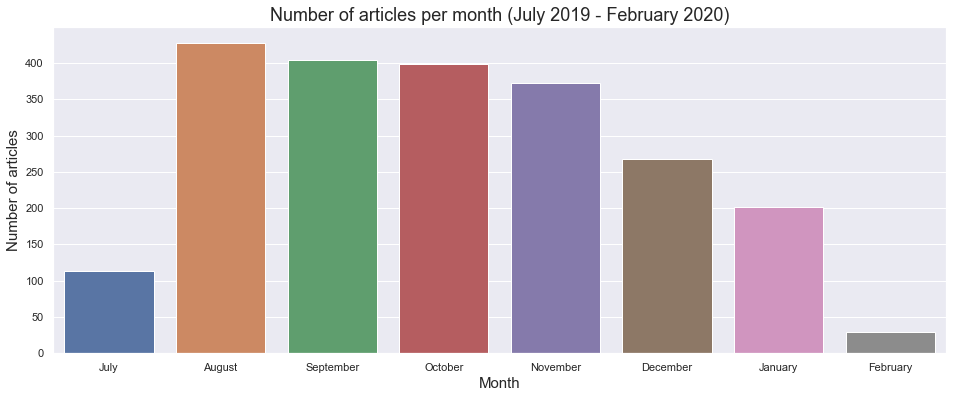

In [110]:
plt.figure(figsize=(16,6))
ax = sns.barplot(x='Month', y='Count' , data=number_articles_per_month, palette='deep')
ax.set_ylabel('Number of articles', fontsize=15)
ax.set_xlabel('Month', fontsize=15)
ax.set_title('Number of articles per month (July 2019 - February 2020)',fontsize=18)
plt.show()

Text(0.5, 1.0, 'The number of articles over the 6 months period')

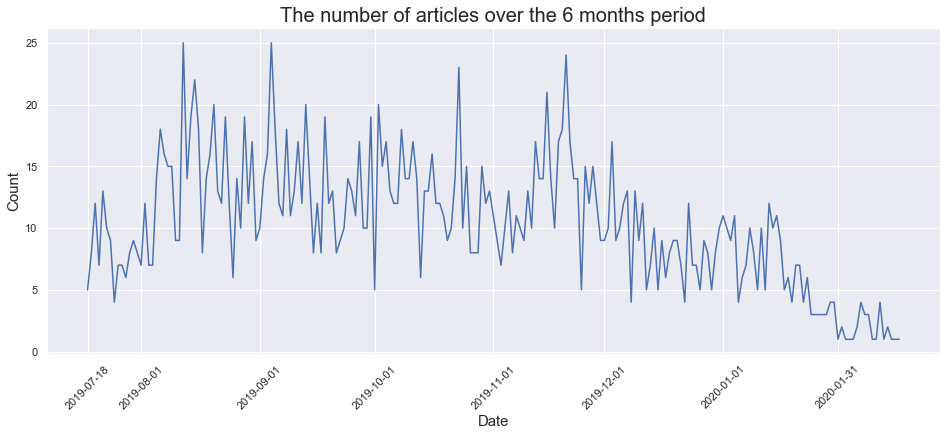

In [112]:
#Number of articles over the observed period.
articles_per_day = df.groupby([df.Date])['Date'].agg(Count='count').reset_index()
plt.figure(figsize=(16,6))
plt.xticks([0, 14, 45, 75, 106, 135, 166, 196])
plt.xticks(rotation='45')
ax = sns.lineplot(x="Date", y="Count", data=articles_per_day)
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Date', fontsize=15)
ax.set_title('The number of articles over the 6 months period', fontsize=20)

### 4.2. Text mining of the article text
I start by counting the top 10 most frequent words in the scraped data. This involves a few steps: 

1. Reading in the 'paragraph' column
2. Convert text to all lowercase and remove all punctuation
3. Splitting the string into a list where each word is a list item by using .str.split()
4. Applying the Counter container to convert the list of lists using a *list comprehension.
5. Applying the .most_common(10) method to get the top 10 most frequent word.


*Without using list comprehension:

    c = Counter()
    for xs in seq:
        for x in set(xs):
            c[x] += 1
    
Output: {'a': 2, 'c': 2, 'b': 2, 'd': 1}


In [262]:
df = pd.read_csv('csv_files/scmp_article_content_all.csv')
df.paragraphs = df.paragraphs.apply(lambda x: x.lower())\
    .apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))\
    .apply(lambda x: x.replace('”','').replace('“',''))
text_dataset = df.paragraphs

In [263]:
from collections import Counter

split_it = text_dataset.str.split()

Counter = Counter(x for xs in split_it for x in xs)
most_occur = Counter.most_common(10)
print(most_occur)

[('the', 97936), ('to', 44423), ('of', 37183), ('and', 35976), ('a', 30769), ('in', 30119), ('said', 19108), ('on', 18336), ('for', 13636), ('hong', 13232)]


As expected the most frequent words are stop words, these are no good to us and will need to be removed.  

Stemming and Lemmatization will need to be carried out, this is done using the Natural Language Tool Kit library (NLTK).

In [270]:
flat_list = [item for sublist in split_it for item in sublist]
# adding to the list of stopwords
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['said','The','would','also','could','–']
stopwords.extend(newStopWords)
clean_split_it = [word for word in flat_list if word not in stopwords]
clean_split_it[:10]

['atrium',
 'landmark',
 'shopping',
 'centre',
 'central',
 '50',
 'people',
 'gathered',
 '1pm',
 'placing']

After the text has been cleaned and split, we then count the word frequency and plot them onto bar charts.

In [271]:
from collections import Counter
clean_list = Counter(clean_split_it)
clean_list
clean_most_occur = clean_list.most_common(10)
clean_least_occur = clean_list.most_common()[-11:-1]

Text(0.5, 1.0, 'Top 10 most common words (excluding stop words)')

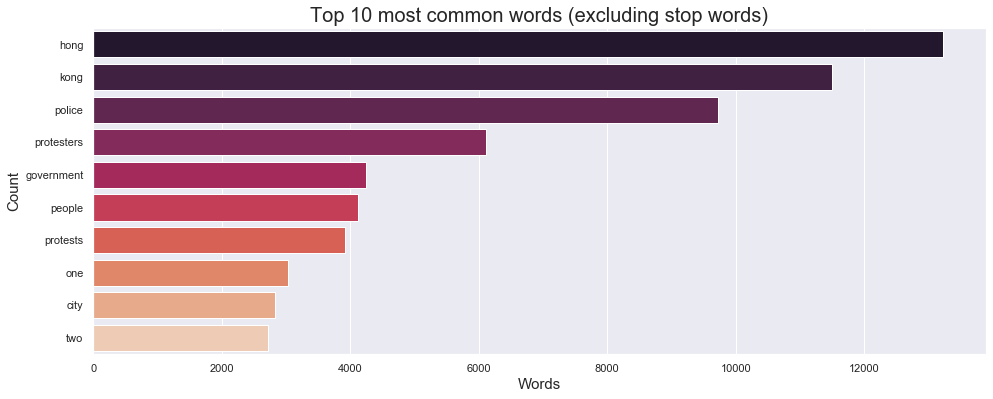

In [272]:
plt.figure(figsize=(16,6))
pd_clean_most_occur = pd.DataFrame(clean_most_occur, columns = ['Words' , 'Count'])
ax = sns.barplot(x='Count', y='Words' , data=pd_clean_most_occur, palette='rocket')
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Words', fontsize=15)
ax.set_title('Top 10 most common words (excluding stop words)', fontsize=20)

Text(0.5, 1.0, 'Top 10 least common words')

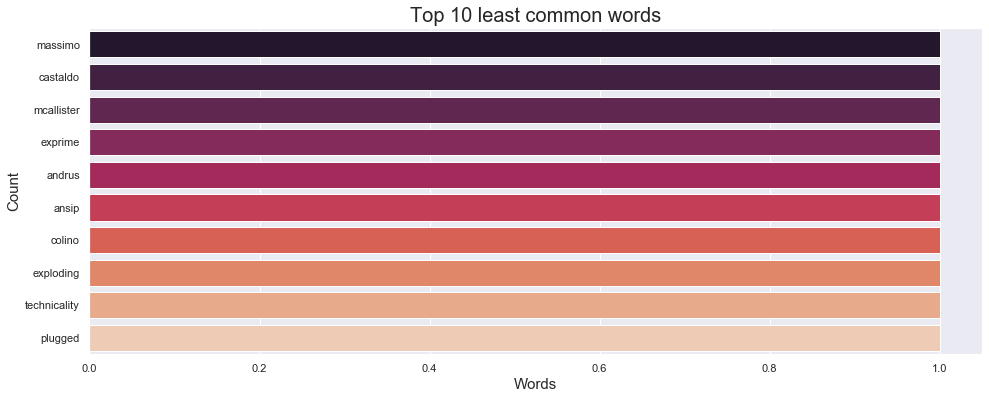

In [273]:
plt.figure(figsize=(16,6))
pd_least_occur = pd.DataFrame(clean_least_occur, columns = ['Words' , 'Count'])
ax = sns.barplot(x='Count', y='Words' , data=pd_least_occur, palette='rocket')
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Words', fontsize=15)
ax.set_title('Top 10 least common words', fontsize=20)

## 5. Sentiment Analysis

In [277]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nicom\AppData\Roaming\nltk_data...


In [281]:
df['neg'] = df['paragraphs'].apply(lambda x:sia.polarity_scores(x)['neg'])
df['nen'] = df['paragraphs'].apply(lambda x:sia.polarity_scores(x)['neu'])
df['pos'] = df['paragraphs'].apply(lambda x:sia.polarity_scores(x)['pos'])
df['compound'] = df['paragraphs'].apply(lambda x:sia.polarity_scores(x)['compound'])

In [282]:
df.head()

,title,summary,date,main_text_title,paragraphs,url,neg,nen,pos,compound
0,"Protests over Yuen Long feature beer, champagn...",Largely peaceful demonstrations feature small ...,"3:55pm, 21 Feb, 2020",Peaceful lunchtime demonstrations intended to ...,at the atrium of the landmark shopping centre ...,https://scmp.com/print/news/hong-kong/politics...,0.120,0.806,0.073,-0.9786
1,Coronavirus: Beijing’s top official in Hong Ko...,Luo Huining asks city’s members of China’s leg...,"11:03pm, 20 Feb, 2020",Beijing’s top envoy in Hong Kong has written t...,luo huining the new director of beijing’s liai...,https://scmp.com/print/news/china/politics/art...,0.063,0.838,0.100,0.9843
2,Anti-government protesters’ slogan spray-paint...,Popular protest refrain ‘Liberate Hong Kong; R...,"10:38pm, 19 Feb, 2020",The eight words in Chinese – “Liberate Hong Ko...,the popular slogan of the monthslong antigover...,https://scmp.com/print/news/hong-kong/law-and-...,0.095,0.867,0.038,-0.8979
3,Hong Kong commerce minister warns RTHK to obse...,Commerce and Economic Development Bureau which...,"5:44pm, 18 Feb, 2020","The force earlier denied the allegation, sayin...",hong kong’s commerce minister has warned publi...,https://scmp.com/print/news/hong-kong/politics...,0.043,0.931,0.026,-0.8310
4,Videos of Hong Kong police officers dining wit...,Banquet was attended by celebrities such as Ch...,"12:18am, 18 Feb, 2020",Videos showing Hong Kong police chief Chris Ta...,the banquet on sunday night was hosted by the ...,https://scmp.com/print/news/hong-kong/society/...,0.059,0.843,0.098,0.9579
